In [22]:
# Loading dependencies
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

from IPython.core.display import HTML

from ipywidgets import interact_manual
import ipywidgets as widgets

%matplotlib inline

# CS 182 Demo: Data Augmentations

A theme that has been discussed throughout the discussion of machine learning and deep learning is regularization. Specifically in this class, we've covered adapting our models to make sure it does not overfit on training data -- that it generalizes well to unseen data. Many of the approaches discussed, such as batch normalization, layer normalization, and dropoout involve tuning and adjusting the inner workings of our deep learning architectures. However, data augmentation provides a different approach to regularizing our models. When working with image data & object detection tasks, a primary goal of developing practical and strong Convolutional Neural Networks (CNNs) is to provide an architecture that has invariances built into it.


## Part 1: Data Augmentation in Theory

Regularization is necessary for deep learning models to generalize well to unseen data (i.e. test data), and it can be introduced into models through explicit methods such as adding a weighted $L_{1}$ or $L_{2}$ penalty, for example, to the loss function. However, regularization can also be introduced implicitly into the model through data augmentation.

Consider an edge or a pattern that consistently appears near the center of an image in a subset of the training data. For example, this might be the stripes of a tiger consistently appearing in the center, due to the images of the tiger consistently being centered on the tiger. The model (i.e. CNN) will latch onto that edge or pattern as it is designed to do. Due to translational/equivariance invariance, the model should be able to detect if the tiger and its stripes were shifted around the image, thus providing the model with information to inform its prediction (ideally, that would be 'tiger').

However, in practicality, images are not always as clean cut as the training examples in datasets such as CIFAR-10. The quality of the image could be poor (bluriness) resulting in the model poorly identifying features, or a glare in the picture that distracts the model from important patterns and edges that result in a correct classification. It might even be possible that the subset of tiger images are entirely centered on a docile tiger standing horizontally, meaning a rotated or 'active' tiger may result in a misclassification.

Thus, data augmentation during training provides a way of implicitly regularizing the model by artifically creating scenarios that could be realistically seen in the real world. These data augmentations force the model to adapt to these changes by relying less on exploiting patterns from idealized version of images. By augmenting our data, we are approximating more what our data looks like in the real world.


Data augmentation is also an avenue for domain knowledge to be exploited to help produce more accurate while still robust models. Experts and scientists can provide encodings of what is important via domain emphasis by selecting data augmentations that accurately represent what the model may encounter post-training.

## Part 2: Basic Augmentations

These augmentations are used to promote invariance to small semantically insignificant changes.

A few basic augmentations are:
1. Random Cropping
2. Rescaling
3. Rotations
3. Subset
4. Color Adjustment
5. Blurring

The basic augmentations included in the lecture are:
1. `autocontrast`
2. `equalize`
3. `posterize`
4. `rotate`
5. `solarize`
6. `shear_{x, y}`
7. `translate_{x, y}`
8. `color`
9. `contrast`
10. `brightness`
11. `sharpness`

### Using PyTorch for Data Augmentation

There are many data augmentations that are implemented in the `torchvision.transforms` modules. Below are a few examples of common data augmentations used in basic ConvNets. Let's load in a sample image of a Golden Retriever to work with.

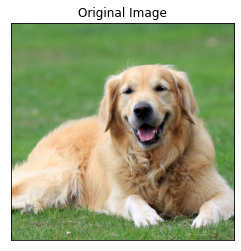

In [102]:
# Read in image as NumPy array
dog = plt.imread("dog.jpg")

# Convert NumPy array to Tensor
dog = torch.from_numpy(dog)

plt.imshow(dog)
plt.xticks([])
plt.yticks([])
plt.title("Original Image");

### Random Rotation
Use the `transforms.RandomRotation` method to randomly rotate an image up to a certain degree.

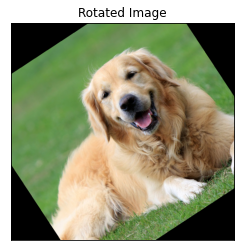

In [103]:
# Set maximum degree you'd like to rotate the image by
MAX_DEGREE = 45

# Rotate image using rotation transformation
rotation = transforms.RandomRotation(degrees=MAX_DEGREE)
dog_rotated = rotation(dog.permute(2,0,1)).permute(1,2,0)

plt.imshow(dog_rotated);
plt.xticks([])
plt.yticks([])
plt.title("Rotated Image");

### Random Crop
Use the `transforms.RandomResizedCrop` method to crop the given image at a random location and then resize to match the original image size. Oftentimes, we fix our model architecture such that it always takes in the same size input image, thus it's important to resize after cropping.

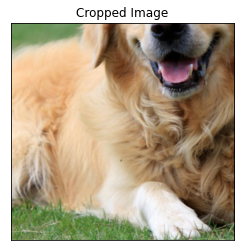

In [104]:
# Crop the input image based on crop size
crop = transforms.RandomResizedCrop(size=dog.shape[:2])
dog_cropped = crop(dog.permute(2,0,1)).permute(1,2,0)

plt.imshow(dog_cropped);
plt.xticks([])
plt.yticks([]);
plt.title("Cropped Image");

Notice that the image size before and after cropping is the same

In [105]:
print(f'Before Crop: {dog.shape}')
print(f'After Crop: {dog_cropped.shape}')

Before Crop: torch.Size([599, 615, 3])
After Crop: torch.Size([599, 615, 3])


### Gaussian Blur
Use the `transforms.GaussianBlur` method to blur the image with randomly chosen Gaussian blur.

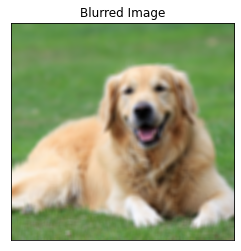

In [106]:
# Set kernel size and variance
KERNEL_SIZE=13
SIGMA_RANGE=(78,100)

# Pass a Gaussian filter over the image
blur = transforms.GaussianBlur(kernel_size=KERNEL_SIZE, sigma=SIGMA_RANGE)
dog_blurred = blur(dog.permute(2,0,1)).permute(1,2,0)

plt.imshow(dog_blurred);
plt.xticks([])
plt.yticks([])
plt.title("Blurred Image");

<div class="alert alert-info"> <b>Try it out:</b> Play around with the <code>KERNEL_SIZE</code> and <code>SIGMA_RANGE</code> variables. How do both the kernel size and the sigma value affect the resulting blur?</div>

### Posterize

Use the `transforms.RandomPosterize` to posterize the image randomly with a given probability by reducing the number of bits for each color channel.

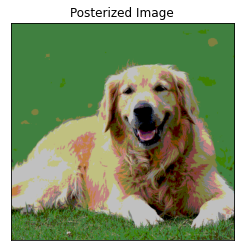

In [107]:
# Set the posterizing parameters
BITS = 2
P = 1

# Rotate image using rotation transformation
posterize = transforms.RandomPosterize(bits=BITS, p=P)
dog_posterized = posterize(dog.permute(2,0,1)).permute(1,2,0)

plt.imshow(dog_posterized);
plt.xticks([])
plt.yticks([])
plt.title("Posterized Image");

# Part 3: Advanced Augmentations

Advanced data augmentations provide more complex and unique training examples to further regularize our model. The real world is complicated and variable, meaning unseen (by the model) data are likely to be complex and dynamic. Thus, Advanced augmentations provide practitioners an ability to introduce more heavily augmented, and sometimes more realistic, data to further improve the models robustness 

### Composing Multiple Augmentations 

As machine learning practitioners, we've found that composing multiple data augmentations together, most often within a PyTorch `DataSet`, helps to improve performance and regularizes the model. Below is an example of one such composition of basic data augmentations.

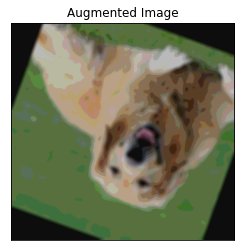

In [135]:
composed_transform = transforms.Compose([
        transforms.RandomRotation(degrees=20),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.GaussianBlur(kernel_size=13, sigma=7),
        transforms.RandomPosterize(bits=3, p=0.9),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
        ])
dog_augmented = composed_transform(dog.permute(2,0,1)).permute(1,2,0)

plt.imshow(dog_augmented)
plt.xticks([])
plt.yticks([])
plt.title("Augmented Image");

### More Aggressive Data Augmentations

As shown in lecture, there are several more aggressive data augmentations that are used in practice. Empircally, they are found to have a regularizing effect on the model. Some examples are below:

<img src="./augmentations.png" width="800px" align="left"></img>

1. Cutout
2. Mixup
3. CutMix
4. <a href="https://arxiv.org/pdf/2112.05135.pdf">PixMix</a>

### PixMix

The PixMix data augmentation strategy comes from the 2022 paper [PIXMIX: Dreamlike Pictures
Comprehensively Improve Safety Measures](https://arxiv.org/pdf/2112.05135.pdf).

<img src="./pixmix.png" width="800px" align="left"></img>

The following is an excerpt from the original PIXMIX paper describing the above image:
> An instance of a PIXMIX augmentation being applied to a bird image. The original clean image is mixed with augmented
versions of itself and an image such as a fractal. Bottom: Sample images from the PIXMIX mixing set. We select fractals and feature
visualizations from manually curated online sources. In ablations, we find that these new sources of visual structure for augmentations
outperform numerous synthetic image distributions explored in prior work [2]."

## Loading the Model Architecture

Let us utilize the AlexNet architecture. The AlexNet architecture consists of five convolutional layers, five ReLU (activation) layers, three max pooling layers, followed by a multi layer perceptron (MLP) with dropout woven within. The AlexNet is a powerful architecture that has had success in object detection tasks within image data.

In [3]:
# Run the following cell to load in the model and visualize the architecture
model = torchvision.models.alexnet(weights=None, num_classes=10)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Loading the Data: CIFAR-10

The CIFAR-10 dataset contains 45,000 images, each labeled as one of the following classes:

0. airplane										
1. automobile										
2. bird										
3. cat										
4. deer										
5. dog										
6. frog										
7. horse										
8. ship										
9. truck

The CIFAR-10 dataset is often used in training and evaluating models due to its large size, but also its simplicity due to its low number of classes

In [4]:
# transform = transforms.Compose([
#     transforms.Resize((224, 224)), # Resize to 224x224 for ResNet models
#     transforms.ToTensor()
# ])

class_to_label = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 
                  5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}

data_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
data_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Display a couple images
@interact_manual(idx=widgets.IntSlider(min=0, max=len(data_train)-1, step=1))
def show_image_with_label(idx):
    """Show an image with a label"""
    im, label = data_train[idx]
    
    # Show image with HTML label
    plt.imshow(im)
    cls = class_to_label.get(label)
    display(HTML(f"<h3>{cls.title()}<h3>"))
    plt.xticks([])
    plt.yticks([])

interactive(children=(IntSlider(value=0, description='idx', max=49999), Button(description='Run Interact', sty…

# Part 4: Augmentations in Practice

In [112]:
model.features[0]

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))